Investigate the glacier-scale and regional-scale trend in water area over time

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [4]:
# matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [5]:
# open the water data for each glacier, format into a single df
c=0
all_series = []
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>10: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['o3region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific cloud info as a pd.Series, append to list   
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_binary_otsuoptimal_188_binned_accaqa.csv')
    
    df_g = pd.read_csv(path_open, index_col=0, header=None).squeeze()
    df_g['o3_region'] = str(o3region).zfill(2)
    all_series.append(df_g)

# format into df
df_all = pd.DataFrame(all_series).reset_index(drop=True)

# format to numeric dtypes
all_cols = df_all.columns
for c in all_cols:
    if c in ['rgi_id', 'o1_region', 'o2_region', 'o3_region']: continue
    df_all[c] = df_all[c].astype(float)

# add extra columns on for each glacier (dc area, etc...)
df_all = df_all.merge(dc_gdf[['rgi_id','area_dc']], on='rgi_id')

# merge with glacier area
print("All done!")

df_big = df_all[df_all['area_dc']>5]

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
All done!


In [6]:
# load in the list of lake-terminating glaciers, so we can remove those if we want
path_open = os.path.join(folder_datasets, 'lake-terminating glaciers', 'rgi_lake_terminating.csv')
df_lake_term = pd.read_csv(path_open)
rgi_lake_term = df_lake_term['rgi_id'].values
# rgi_lake_term

In [7]:
# create subsets of lake terminating vs non-lake terminating so we can compare
df_all_lt = df_all[df_all['rgi_id'].isin(rgi_lake_term)]
df_all_nlt = df_all[~df_all['rgi_id'].isin(rgi_lake_term)]

In [8]:
# select which df to use from here
df_to_use = df_all_nlt #df_all df_all_nlt

In [9]:
# define annual columns, 5-year columns
# intervals = [ [1990,1994],[1995,1999],[2000,2004],[2005,2009],[2010,2014],[2015,2019],[2020,2023] ]
ys = [1988,1990,1992,1994,1996,1998,2000,2002,2004] + list(range(2005,2024))
c_1yr = [ f"water_{y}_m2" for y in ys ]

In [10]:
# plot annual timeseries of a single glacier ( provide either glacier name or rgi_id)
def plot_single_glacier(rgi_id, glacier_name):

    # get the rgi_id if glacier name was provided
    if glacier_name: rgi_id = rgi_gdf[rgi_gdf['glac_name'].str.contains(glacier_name)==True]['rgi_id'].values[0]
    g_df = df_all[df_all['rgi_id']==rgi_id]
    glacier_name = rgi_gdf[rgi_gdf['rgi_id']==rgi_id]['glac_name'].values[0]

    # formatting of data
    c_1yr_term = [ f"water_{y}_terminus_m2" for y in ys ]
    areas_all = g_df[c_1yr].values[0]/10000
    areas_terminus = g_df[c_1yr_term].values[0]/10000
    ymax = np.nanmax(areas_all)*1.1
    dc_area = g_df['area_dc'].values[0]#*(1000*1000)/10000 /100

    # initiate figure
    fig,axs = plt.subplots(figsize=(8,4))
    ax2 = axs.twinx() # twin axis for showing percentage

    # plot the data
    axs.plot( ys, areas_all, label='Entire Glacier')
    axs.plot( ys, areas_terminus, label='Lower Half Only')
    ax2.plot(ys, areas_all/dc_area)

    axs.grid(zorder=1, linestyle='dashed')
    axs.set_xlabel("Year")
    axs.set_ylabel("SGL Area (x10000 m2)")
    ax2.set_ylabel("SGL Area (%)")

    # override ymax if you want
    # ymax=22
    axs.set_ylim(0,ymax)
    ax2.set_ylim(0,ymax/dc_area)

    axs.legend()
    axs.set_title(f"Name: {glacier_name}\nRGI_ID: {rgi_id}")
    plt.tight_layout()

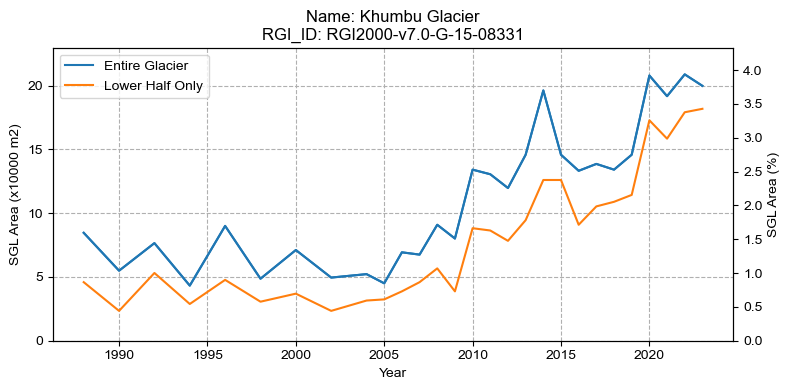

In [11]:
rgi_id = 'RGI2000-v7.0-G-15-09532' # choose which you want to provide
glacier_name = 'Khumbu'
plot_single_glacier(rgi_id, glacier_name)

In [12]:
# sneaky save csv holding entire region's timeseries so we can use in other plots
sgl_areas_nlt = df_all_nlt[c_1yr].sum(axis=0).values
sgl_areas_all = df_all[c_1yr].sum(axis=0).values

out_df = pd.DataFrame({'year':ys,
                       'area_nlt_km2':sgl_areas_nlt/(1000*1000),
                       'area_all_km2':sgl_areas_all/(1000*1000)})
out_path = os.path.join(folder_datasets, 'total_lake_area_annual.csv')
# out_df.to_csv(out_path, index=False)

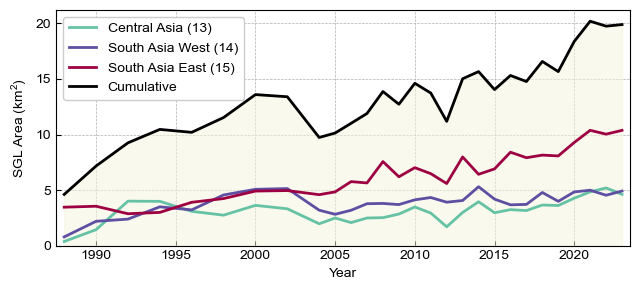

In [13]:
# plot time series of total sgl area across the region, and individual subregions

df_o1 = df_all_nlt.groupby("o1_region").sum(numeric_only=True)
df_o1T = df_o1[c_1yr].T

cs = plt.cm.Spectral(np.linspace(0, 1, 6))

# initiate figure
fig,ax = plt.subplots(figsize=(6.5,3))

# 13
ax.plot( ys, df_o1T['13'].values/(1000*1000),
        label='Central Asia (13)', linewidth=2, color=cs[4], zorder=3)

# 14
ax.plot( ys, df_o1T['14'].values/(1000*1000),
        label='South Asia West (14)', linewidth=2, color=cs[-1], zorder=3)

# 15
ax.plot( ys, df_o1T['15'].values/(1000*1000),
        label='South Asia East (15)', linewidth=2, color=cs[0], zorder=3)

# plot entire region total
sgl_areas = df_all_nlt[c_1yr].sum(axis=0).values
# fill below the curve
ax.fill_between(ys, sgl_areas/(1000*1000), color='beige', alpha=0.5, zorder=2)
ax.plot( ys, sgl_areas/(1000*1000),
        label="Cumulative", color='black', linewidth=2, zorder=2)

ax.set_xlabel("Year")
ax.set_ylabel("SGL Area (km$^2$)")
ax.set_ylim(0,)
ax.set_xlim(1987.5,2023.5)

ax.tick_params(axis="both",direction="in")
ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)

ax.legend(framealpha=1)

plt.tight_layout()



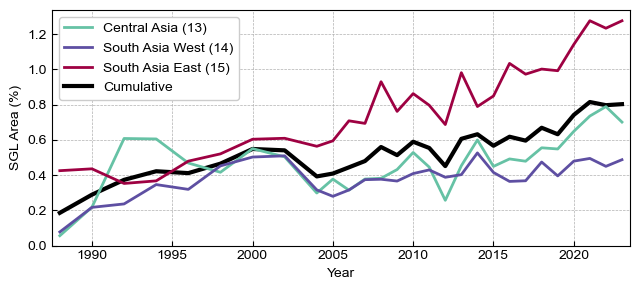

In [14]:
# make a more publication-ready figure that combines total region and subregions

df_o1 = df_all_nlt.groupby("o1_region").sum(numeric_only=True)
df_o1T = df_o1[c_1yr].T

cs = plt.cm.Spectral(np.linspace(0, 1, 6))

fig,ax = plt.subplots(figsize=(6.5,3))

# 13
ax.plot( ys, df_o1T['13'].values / (df_o1.loc['13']['area_dc']*1000*1000) * 100,
        label='Central Asia (13)', linewidth=2, color=cs[4], zorder=3)

# 14
ax.plot( ys, df_o1T['14'].values / (df_o1.loc['14']['area_dc']*1000*1000) * 100,
        label='South Asia West (14)', linewidth=2, color=cs[-1], zorder=3)

# 15
ax.plot( ys, df_o1T['15'].values / (df_o1.loc['15']['area_dc']*1000*1000) * 100,
        label='South Asia East (15)', linewidth=2, color=cs[0], zorder=3)

# plot entire region total
dc_area = np.nansum(df_all_nlt['area_dc'])
sgl_areas = df_all_nlt[c_1yr].sum(axis=0).values/(1000*1000)
ax.plot( ys, sgl_areas/dc_area*100,
        label="Cumulative", color='black', linewidth=3, zorder=2)


ax.set_xlabel("Year")
ax.set_ylabel("SGL Area (%)")
ax.set_ylim(0,)
ax.set_xlim(1987.5,2023.5)

ax.tick_params(axis="both",direction="in")
ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)

ax.legend(framealpha=1)

plt.tight_layout()



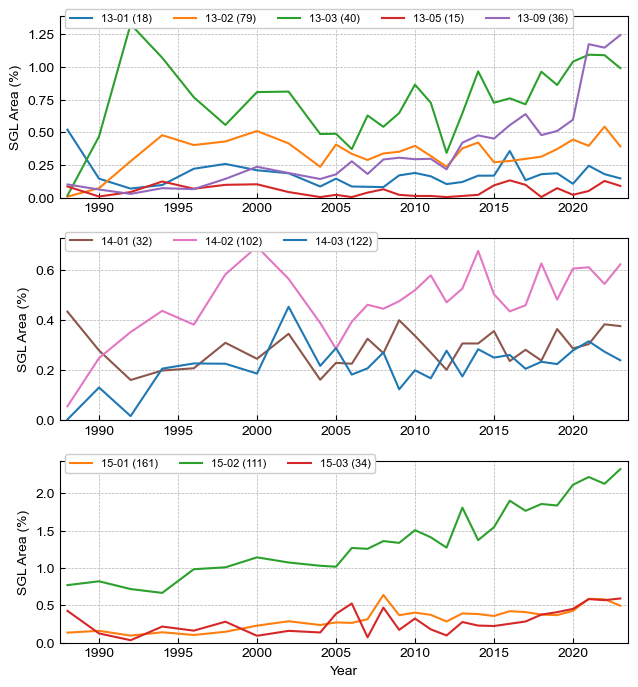

In [76]:
# plot the annual timeseries of each o2region, grouped in plots by o3region
fig,axs = plt.subplots(3,1, figsize=(6.5,7), sharey='row')

# do you want to count number of total glaciers, or non-lake-temrinating?
count_o2 = df_all_nlt.groupby("o2_region").count()['rgi_id']

# iterate through a color ramp. new color for each line
colors_to_use = iter( list(plt.cm.tab10(np.linspace(0, 0.69, 7))) +
                      list(plt.cm.tab10(np.linspace(0, 0.69, 7))) )

# excluding lake-terminating
df_o2 = df_all_nlt.groupby("o2_region").sum(numeric_only=True)
subset = df_o2[c_1yr].T
for c in subset.columns:
    ax = axs[int(c[:2])-13]
    dc_area = df_o2.loc[c]['area_dc']*1000*1000
    ng = count_o2[c]
    ax.plot( ys, subset[c].values / (dc_area) * 100, label=f"{c} ({ng})", c=next(colors_to_use) )

for ax in axs:
    ax.tick_params(axis="both",direction="in")
    ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
    ax.set_ylabel("SGL Area (%)")
    ax.set_xlim(1987.5, 2023.5)
    ax.set_ylim(0,)
    
axs[-1].set_xlabel("Year")

axs[0].legend(loc='lower left', ncols=5, bbox_to_anchor=(0, 0.9), fontsize=8, framealpha=1)
axs[1].legend(loc='lower left', ncols=3, bbox_to_anchor=(0, 0.9), fontsize=8, framealpha=1)
axs[2].legend(loc='lower left', ncols=3, bbox_to_anchor=(0, 0.9), fontsize=8, framealpha=1)

plt.tight_layout()